Download packages

In [1]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import warnings
from sklego.meta import OrdinalClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from itertools import cycle, islice
import matplotlib.patches as mpatches
from sklearn.cluster import HDBSCAN, OPTICS, DBSCAN
import scipy



In [2]:
random.seed(8)

Create new feature names to take the mean and std across epochs pr person

In [3]:
m_list = ['Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR'] 
mean_list = [i + '_mean' for i in m_list]
std_list = [i + '_std' for i in m_list]
print(mean_list)

['Delta_mean', 'Delta_N_mean', 'Theta_mean', 'Theta_N_mean', 'Alpha_mean', 'Alpha_N_mean', 'Beta_mean', 'Beta_N_mean', 'Gamma_mean', 'Gamma_N_mean', 'SE_mean', 'MSF_mean', 'Sef90_mean', 'Sef95_mean', 'PE_mean', 'wSMI_mean', 'Kolmogorov_mean', 'MeanRR_mean', 'StdRR_mean', 'MeanHR_mean', 'StdHR_mean', 'MinHR_mean', 'MaxHR_mean']


Concatenate data

In [4]:
import sklearn.preprocessing


path ='CSV_individual_cross_val/'
folder = os.fsencode(path)
renamed_markers_list = ['No.', 'Event', 'Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
m_list = ['Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
mean_list = [i + '_mean' for i in m_list]
std_list = [i + '_std' for i in m_list]


patient_numbers = []
r_data = []
m_data = []
f_data = []

all_data = []


for file in os.listdir(folder):
    filename = os.fsdecode(file)
    patient_numbers.append(filename[0:3])
    fname = path + filename
    data = pd.read_csv(fname)
    data.columns = renamed_markers_list
    sklearn.preprocessing.StandardScaler().set_output(transform='pandas') 
    data[m_list] = sklearn.preprocessing.StandardScaler().fit(data[m_list]).transform(data[m_list]) #standardising data within each patient
    
    all_data.append(data)




In [5]:
#fit pca across patients
data_for_pca = pd.concat(all_data)
pca = sklearn.decomposition.PCA(n_components=0.95)
components = pca.fit(data_for_pca[m_list]).components_


Inspecting optimal number of components to use

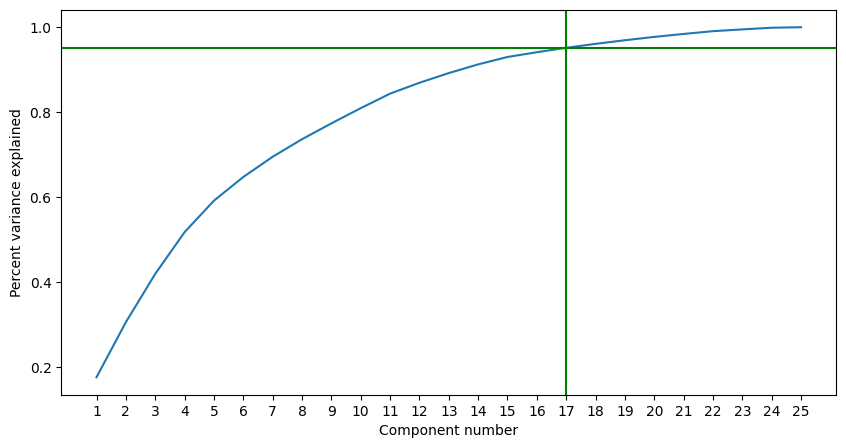

In [7]:
#done with all components
exp_var = pca.explained_variance_ratio_
plt.figure(figsize = (10, 5))
plt.plot(np.arange(1,26,1), exp_var.cumsum())
plt.xticks(np.arange(1,26,1))
plt.xlabel('Component number')
plt.ylabel('Percent variance explained')
plt.axvline(17, color='g')
plt.axhline(0.95, color='g')

Ignore irrelevant warnings

In [6]:
warnings.filterwarnings(action='ignore', category=FutureWarning)

Forward feature selection for each person to find relevant features

In [7]:
import sklearn.model_selection
A = set()
components_n = components.shape[0]
t = pd.CategoricalDtype(categories = ['R', 'M', 'F'], ordered = True)

feat_scores = np.zeros(components_n)

for i in range(len(all_data)):
    train_y = pd.Series(all_data[i]['Event'],dtype=t).cat.codes
    train_X = all_data[i][m_list]
    train_X = pca.transform(train_X)
    train_X = pd.DataFrame(train_X)
    ord_clf = OrdinalClassifier(estimator=LogisticRegression())
    for j in range(components_n):
        skf = StratifiedKFold(n_splits=3)
        #print(np.array(train_X.iloc[:,j]))
        #print(np.array(train_y))
        scores = sklearn.model_selection.cross_val_score(ord_clf, np.array(train_X.iloc[:,j]).reshape(-1, 1), np.array(train_y), cv = skf, scoring='balanced_accuracy')
        score = scores.sum()
        result = scipy.stats.ttest_1samp(scores, 1/3, alternative='greater')
        if result.pvalue <0.01:
            #print('person: ',i,j, 'has score: ', scores)
            A.add(i)
        feat_scores[j] += score

print(feat_scores)




c:\Users\CHVI0030\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\CHVI0030\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\CHVI0030\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\CHVI0030\A

[78.27777778 71.         75.02777778 74.72222222 76.19444444 72.83333333
 73.27777778 77.41666667 73.08333333 72.02777778 72.38888889 73.08333333
 75.52777778 73.16666667 79.11111111 76.72222222 74.05555556]


In [8]:
first_feature = np.argmax(feat_scores)

In [9]:
print(pca.explained_variance_ratio_)

[0.17568396 0.12957078 0.11373468 0.09834585 0.07417183 0.05575638
 0.04762804 0.04130942 0.03730857 0.035867   0.03417238 0.02561078
 0.02285688 0.02044259 0.01747215 0.01119912 0.01041772]


Finding second optimal PCA component to choose

In [100]:

t = pd.CategoricalDtype(categories = ['R', 'M', 'F'], ordered = True)
B = set()
feat_scores_r2 = np.zeros(components_n)
all_scores = np.empty((len(all_data), components_n))

for i in range(len(all_data)):
    train_y = pd.Series(all_data[i]['Event'],dtype=t).cat.codes
    train_X = all_data[i][m_list]
    train_X = pca.transform(train_X)
    train_X = pd.DataFrame(train_X)
    ord_clf = OrdinalClassifier(estimator=LogisticRegression())

    for j in range(components_n):
        if j != first_feature:

            skf = StratifiedKFold(n_splits=3)
            #print(np.array(train_X.iloc[:,j]))
            #print(np.array(train_y))
            scores = sklearn.model_selection.cross_val_score(ord_clf, np.array(train_X.iloc[:,[first_feature,j]]), np.array(train_y), cv = skf, scoring='balanced_accuracy')
            score = scores.sum()
            mean = scores.mean()
            result = scipy.stats.ttest_1samp(scores, 1/3, alternative='greater')
            if result.pvalue < 0.05:
                #print('hurra person: ',i,j, 'has score: ', scores)
                B.add(i)
            
            feat_scores_r2[j] += score
            all_scores[i,j] = mean


c:\Users\CHVI0030\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\CHVI0030\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\CHVI0030\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\CHVI0030\A

In [38]:
print('First set of persons with significantly higher accuracy than 0.33', sorted(A), len(A))
print('Second set of persons with significantly higher accuracy than 0.33', sorted(B), len(B))


# union 
print("Union :", sorted(A | B), len(A | B)) 
  
# intersection 
print("Intersection :", sorted(A & B), len(A & B)) 
  
# difference 
print("Difference first-second round:", sorted(A - B), len(A - B)) 
print("Difference second-first round:", sorted(B - A), len(B - A)) 



First set of persons with significantly higher accuracy than 0.33 [6, 8, 13, 16, 19, 22, 25, 38, 49, 51, 52, 59, 70] 13
Second set of persons with significantly higher accuracy than 0.33 [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 19, 21, 22, 25, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 44, 46, 49, 51, 52, 53, 56, 59, 60, 62, 66, 67, 68, 69, 71] 43
Union : [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 16, 17, 19, 21, 22, 25, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 44, 46, 49, 51, 52, 53, 56, 59, 60, 62, 66, 67, 68, 69, 70, 71] 44
Intersection : [6, 8, 13, 16, 19, 22, 25, 38, 49, 51, 52, 59] 12
Difference first-second round: [70] 1
Difference second-first round: [1, 2, 3, 4, 5, 7, 9, 11, 12, 17, 21, 28, 30, 31, 32, 33, 34, 35, 36, 39, 44, 46, 53, 56, 60, 62, 66, 67, 68, 69, 71] 31


In [39]:
persons_from_cross_val = [patient_numbers[i] for i in sorted(B)]
print(persons_from_cross_val)

['p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p21', 'p22', 'p23', 'p27', 'p28', 'p2_', 'p31', 'p32', 'p35', 'p38', 'p3_', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p47', 'p48', 'p52', 'p54', 'p58', 'p5_', 'p60', 'p61', 'p65', 'p68', 'p69', 'p71', 'p75', 'p77', 'p78', 'p79', 'p80']


In [101]:

#print(feat_scores_r2)
#print(np.argmax(feat_scores_r2))
second_feature = np.argmax(feat_scores_r2) 

In [102]:
print(first_feature, second_feature)

sort1 = np.argsort(abs(np.array(components[first_feature])))[::-1]
sort2 = np.argsort(abs(np.array(components[second_feature])))[::-1]
#print([(components[0][i], m_list[i]) for i in range(25)])
#print(components[0])
print([(m_list[j], components[first_feature][j]) for j in sort1[0:5]])
print([(m_list[j], components[second_feature][j]) for j in sort2[0:5]])

14 7
[('MSF', -0.5026683070878373), ('Delta_N', 0.4357339048069173), ('Beta', 0.38218004685788043), ('Kolmogorov', 0.360372700718073), ('Delta', -0.33962736647448893)]
[('freq_slope_std', 0.5314301039538447), ('Theta_N', -0.3538484373075634), ('Alpha_N', 0.3429574636105816), ('Alpha', 0.31358653372845163), ('freq_slope_mean', -0.2826093147558914)]


Boxplots for CV accuracies (after 2. step, thereby with 2 components)

In [103]:
cv_scores = all_scores[:,7]
responders = []
non_responders = []

for i in range(len(all_data)):
    if i in B:
        responders.append(cv_scores[i])
    else:
        non_responders.append(cv_scores[i])

In [105]:
# Group sizes
print('Number of responders: ', len(responders))
print('Number of non-responders: ', len(non_responders))

Number of responders:  43
Number of non-responders:  31


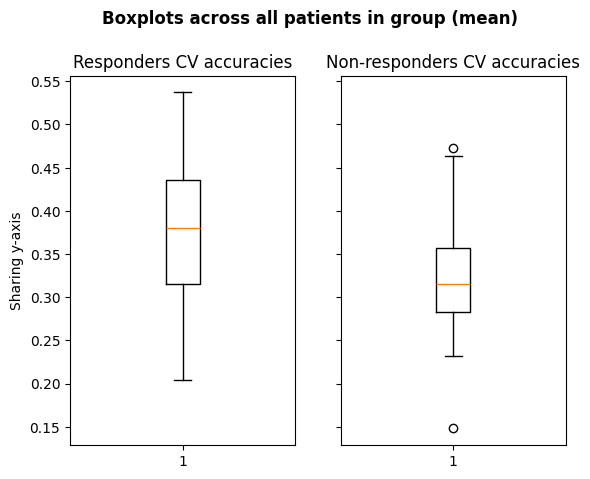

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.boxplot(responders)
ax2.boxplot(non_responders)
ax1.set_title('Responders CV accuracies')
ax2.set_title('Non-responders CV accuracies')
fig.suptitle('Boxplots across all patients in group (mean)', verticalalignment='bottom', fontweight='bold')
ax1.set_ylabel('Sharing y-axis')
plt.show()

# Clustering begin

In [13]:
r_data = []
m_data = []
f_data = []
renamed_markers_list = ['No.', 'Event', 'Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
m_list = ['Delta', 'Delta_N', 'Theta', 'Theta_N', 'Alpha', 'Alpha_N', 'Beta', 'Beta_N', 'Gamma', 'Gamma_N', 'SE', 'MSF', 'Sef90', 'Sef95', 'PE', 'wSMI', 'Kolmogorov', 'MeanRR', 'StdRR', 'MeanHR', 'StdHR', 'MinHR', 'MaxHR', 'freq_slope_mean','freq_slope_std'] 
mean_list = [i + '_mean' for i in m_list]
std_list = [i + '_std' for i in m_list]

for data in all_data:
    R_indicesToKeep = data['Event'] == 'R'
    df_r = data.loc[R_indicesToKeep]

    M_indicesToKeep = data['Event'] == 'M'
    df_m = data.loc[M_indicesToKeep]

    F_indicesToKeep = data['Event'] == 'F'
    df_f = data.loc[F_indicesToKeep]

    r_mean = pd.DataFrame(df_r[m_list].mean(axis=0)).transpose()
    m_mean = pd.DataFrame(df_m[m_list].mean(axis=0)).transpose()
    f_mean = pd.DataFrame(df_f[m_list].mean(axis=0)).transpose()

    r_mean.columns = mean_list
    m_mean.columns = mean_list
    f_mean.columns = mean_list

    r_std = pd.DataFrame(df_r[m_list].std(axis=0)).transpose()
    m_std = pd.DataFrame(df_m[m_list].std(axis=0)).transpose()
    f_std = pd.DataFrame(df_f[m_list].std(axis=0)).transpose()
        
    r_std.columns = std_list
    m_std.columns = std_list
    f_std.columns = std_list
    
    rest = pd.concat([r_mean,r_std],axis=1).to_numpy()
    med = pd.concat([m_mean,m_std],axis=1).to_numpy()
    fam = pd.concat([f_mean,f_std],axis=1).to_numpy()

    r_data.append(rest[0])
    m_data.append(med[0])
    f_data.append(fam[0])

In [14]:
X = [f_data[i] - r_data[i] for i in range(len(r_data))] + [m_data[i] - r_data[i] for i in range(len(r_data))]
y = [i for i in range(0,len(r_data))] + [i for i in range(0,len(r_data))]


### pca transform data

In [15]:
warnings.filterwarnings(action='ignore', category=UserWarning)
X_pca = [np.append(pca.transform(X[i][0:25].reshape(1,-1)),pca.transform(X[i][25:].reshape(1,-1))) for i in range(len(X))]

In [16]:
X_pca_array = np.asarray(X_pca)
print(X_pca_array.shape)

(148, 34)


### take chosen components from data and fit clustering algorithms

In [17]:
b= mean_list+std_list
min_size = 5
chosen_features = [first_feature, second_feature]
ind = [True if i in chosen_features else False for i in range(components_n)] + [True if i in chosen_features else False for i in range(components_n)]
X_pca_chosen = X_pca_array[:,ind]   
    
sclustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=0).fit(X_pca_chosen)
sy_pred = sclustering.labels_

hdb = HDBSCAN(min_cluster_size=min_size).fit(X_pca_chosen)
hy_pred = hdb.labels_
patient_numbers2 = patient_numbers+patient_numbers

dclustering = DBSCAN(min_samples=min_size).fit(X_pca_chosen)
dy_pred = dclustering.labels_    

oclustering = OPTICS(min_samples=min_size).fit(X_pca_chosen)
oy_pred = oclustering.labels_

Plotting dendogram for HDBSCAN

In [18]:
import scipy.cluster.hierarchy as spc
#import hdbscan
#clust = hdbscan.HDBSCAN(min_cluster_size=5).fit(X_pca_chosen)
df = pd.DataFrame(hy_pred)

#pdist = spc.distance.pdist(df)
linkage = spc.linkage(df, method='ward', metric='euclidean')
idx = spc.fcluster(linkage, t=3, criterion='maxclust')


In [27]:
linkage.shape

(147, 4)

(array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125,
        135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235, 245]),
 [Text(5, 0, '147'),
  Text(15, 0, '146'),
  Text(25, 0, '145'),
  Text(35, 0, '144'),
  Text(45, 0, '143'),
  Text(55, 0, '142'),
  Text(65, 0, '141'),
  Text(75, 0, '139'),
  Text(85, 0, '138'),
  Text(95, 0, '137'),
  Text(105, 0, '136'),
  Text(115, 0, '135'),
  Text(125, 0, '134'),
  Text(135, 0, '133'),
  Text(145, 0, '132'),
  Text(155, 0, '131'),
  Text(165, 0, '130'),
  Text(175, 0, '129'),
  Text(185, 0, '128'),
  Text(195, 0, '127'),
  Text(205, 0, '126'),
  Text(215, 0, '(116)'),
  Text(225, 0, '(5)'),
  Text(235, 0, '140'),
  Text(245, 0, '(5)')])

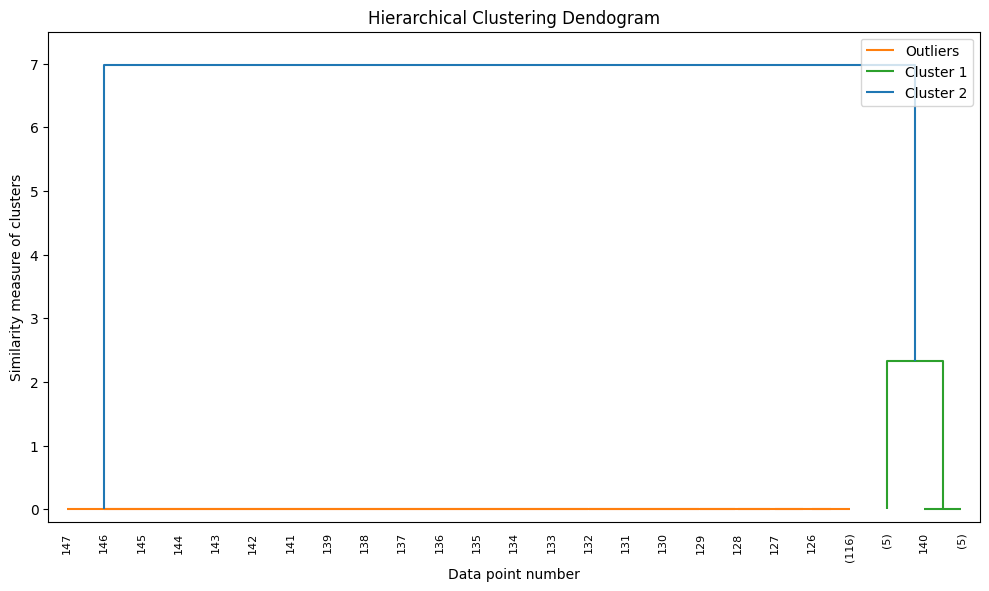

In [36]:
fig = plt.figure(figsize=(10, 6))
plt.title('Hierarchical Clustering Dendogram')
dn = spc.dendrogram(linkage, leaf_font_size=8, truncate_mode='lastp', p=25)
plt.legend(['Outliers', 'Cluster 1', 'Cluster 2'])
plt.xlabel('Data point number')
plt.ylabel('Similarity measure of clusters')
plt.ylim(-0.2,7.5)
plt.tight_layout()
plt.xticks(rotation=90)


In [74]:
den = np.array(dn['color_list'])

count = np.unique(den, return_counts=True)
print(count)

(array(['C0', 'C1', 'C2'], dtype='<U2'), array([  1, 136,  10], dtype=int64))


### plot clustering

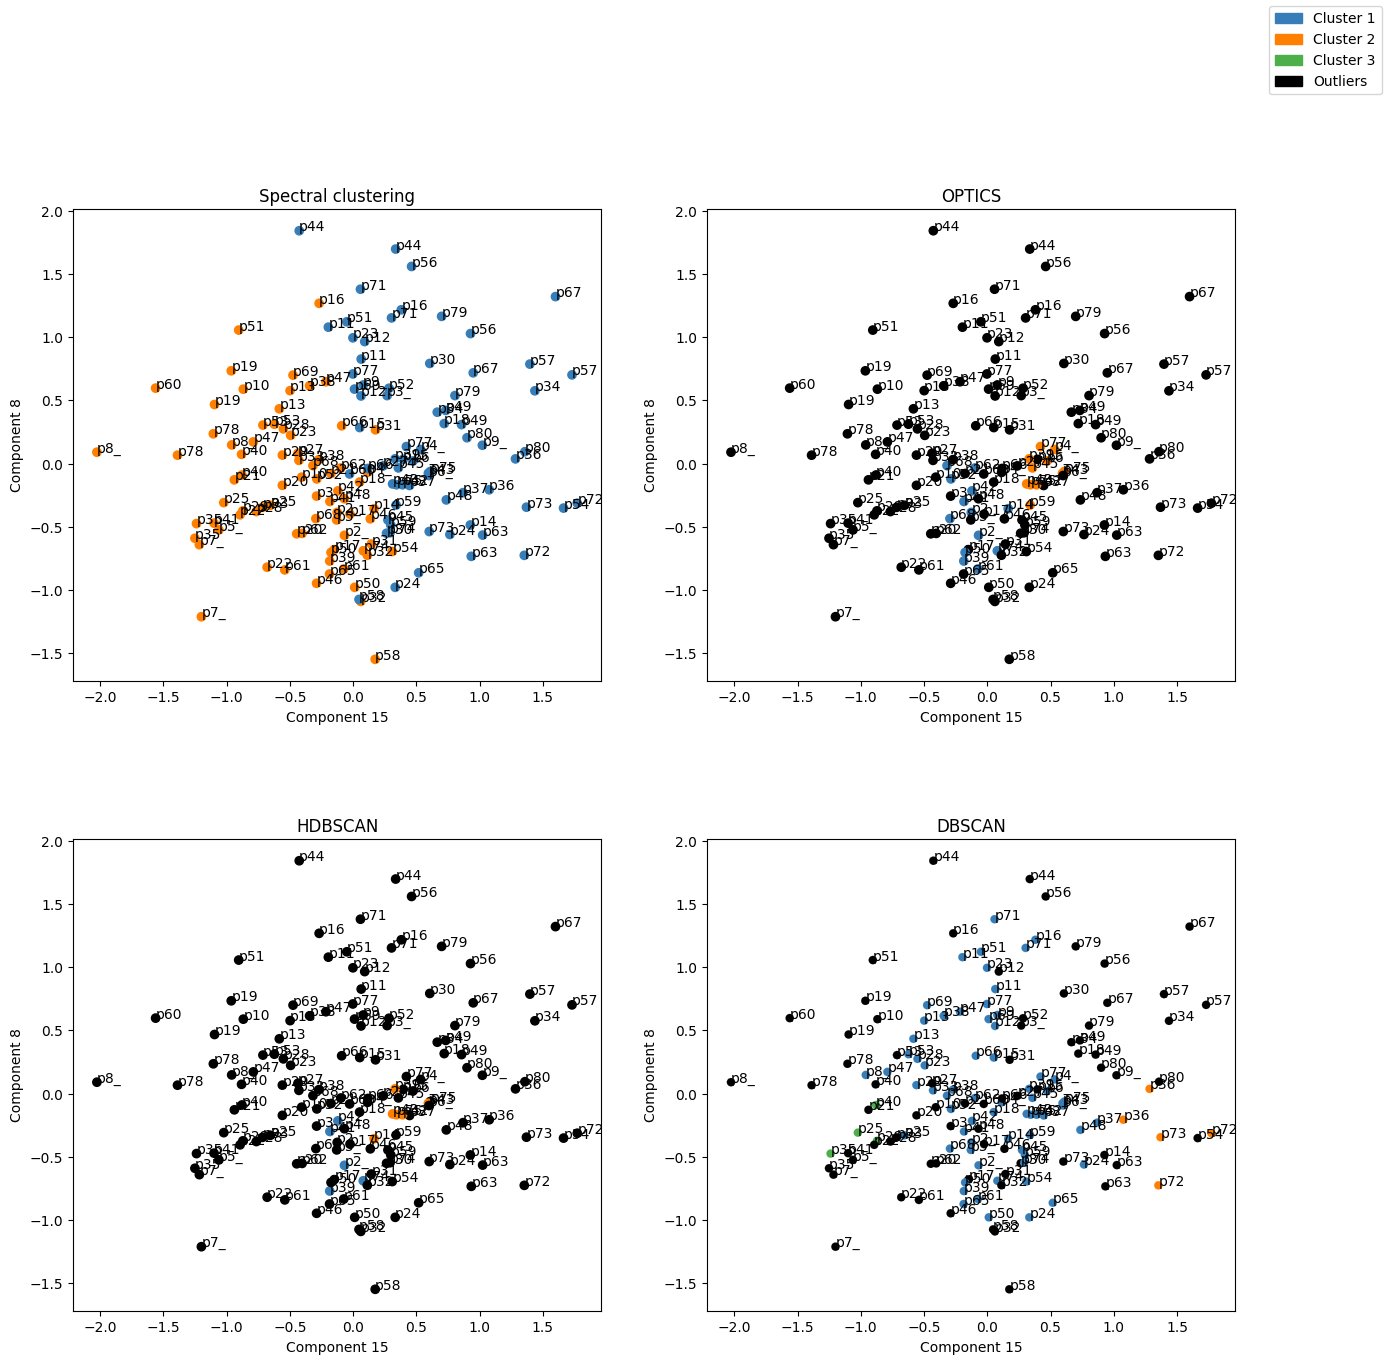

In [26]:
fig, ax = plt.subplots(2,2, figsize=(15,15))

colors = np.array(
    list(
        islice(
            cycle(
                [
                    "#377eb8",
                    "#ff7f00",
                    "#4daf4a", 
                    "#f781bf",
                    "#a65628",
                    "#984ea3",
                    "#999999",
                    "#e41a1c",
                    "#dede00",
                ]
            ),
            int(max(np.concatenate((dy_pred, hy_pred, oy_pred, sy_pred)))+1),
        )
    )
)

# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
ax[0,0].scatter(X_pca_chosen[:, 0], X_pca_chosen[:, -1], c=colors[sy_pred])
for i, txt in enumerate(y):
    ax[0,0].annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, -1]))
ax[0,0].set_aspect('equal', adjustable=None, anchor=None, share=False)
ax[0,0].set_title('Spectral clustering')
ax[0,0].set_xlabel('Component 15')
ax[0,0].set_ylabel('Component 8')

ax[0,1].scatter(X_pca_chosen[:, 0], X_pca_chosen[:, -1], c=colors[oy_pred])
for i, txt in enumerate(y):
    ax[0,1].annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, -1]))
ax[0,1].set_aspect('equal', adjustable=None, anchor=None, share=False)
ax[0,1].set_title('OPTICS')
#ax[0,1].legend()
ax[0,1].set_xlabel('Component 15')
ax[0,1].set_ylabel('Component 8')

ax[1,0].scatter(X_pca_chosen[:, 0], X_pca_chosen[:, -1], c=colors[hy_pred])
for i, txt in enumerate(y):
    ax[1,0].annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, -1]))
ax[1,0].set_aspect('equal', adjustable=None, anchor=None, share=False)
ax[1,0].set_title('HDBSCAN')
#ax[1,0].legend()
ax[1,0].set_xlabel('Component 15')
ax[1,0].set_ylabel('Component 8')

ax[1,1].scatter(X_pca_chosen[:, 0], X_pca_chosen[:, -1], c=colors[dy_pred], linewidth = 0.1)
for i, txt in enumerate(y):
    ax[1,1].annotate(patient_numbers[txt], (X_pca_chosen[i, 0], X_pca_chosen[i, -1]))
ax[1,1].set_aspect('equal', adjustable=None, anchor=None, share=False)
ax[1,1].set_title('DBSCAN')
ax[1,1].set_xlabel('Component 15')
ax[1,1].set_ylabel('Component 8')
#ax[1,1].legend()
pop_a = mpatches.Patch(color="#377eb8", label='Cluster 1') 
pop_b = mpatches.Patch(color="#ff7f00", label='Cluster 2')
pop_d = mpatches.Patch(color="#4daf4a", label='Cluster 3')
pop_c = mpatches.Patch(color="#000000", label='Outliers')
fig.legend(handles=[pop_a,pop_b,pop_d,pop_c]) 

### find different cluster groups

In [106]:
#adding wether it is familiar-resting or unfamiliar-resting datapoint
patient_numbers_with_event = [patient_num +'-fr' for patient_num in patient_numbers] + [patient_num +'-mr' for patient_num in patient_numbers] 

In [107]:
#finding each label for each patient
sy_groups = [(sy_pred[i], patient_numbers_with_event[i]) for i in range(len(sy_pred))]
oy_groups = [(oy_pred[i], patient_numbers_with_event[i]) for i in range(len(oy_pred))]
hy_groups = [(hy_pred[i], patient_numbers_with_event[i]) for i in range(len(hy_pred))]
dy_groups = [(dy_pred[i], patient_numbers_with_event[i]) for i in range(len(dy_pred))]

In [108]:
#cluster sizes
sy_groups_counts = list(zip(*np.unique(sy_pred, return_counts=True)))
oy_groups_counts = list(zip(*np.unique(oy_pred, return_counts=True)))
hy_groups_counts = list(zip(*np.unique(hy_pred, return_counts=True)))
dy_groups_counts = list(zip(*np.unique(dy_pred, return_counts=True)))
print(sy_groups_counts)
print(oy_groups_counts)
print(hy_groups_counts)
print(dy_groups_counts)

[(0, 71), (1, 77)]
[(-1, 124), (0, 13), (1, 11)]
[(-1, 137), (0, 5), (1, 6)]
[(-1, 72), (0, 67), (1, 5), (2, 4)]


In [66]:
#cluster sorted
sort_sy = sorted(sy_groups, key = lambda x: (x[0],x[1]))[::-1]
sort_oy = sorted(oy_groups, key = lambda x: (x[0],x[1]))[::-1]
sort_hy = sorted(hy_groups, key = lambda x: (x[0],x[1]))[::-1]
sort_dy = sorted(dy_groups, key = lambda x: (x[0],x[1]))[::-1]
print(sort_sy)
print(sort_oy)
print(sort_hy)
print(sort_dy)

[(1, 'p8_-mr'), (1, 'p8_-fr'), (1, 'p7_-mr'), (1, 'p7_-fr'), (1, 'p78-mr'), (1, 'p78-fr'), (1, 'p74-fr'), (1, 'p69-mr'), (1, 'p68-mr'), (1, 'p68-fr'), (1, 'p66-fr'), (1, 'p65-mr'), (1, 'p62-mr'), (1, 'p62-fr'), (1, 'p61-mr'), (1, 'p61-fr'), (1, 'p60-mr'), (1, 'p5_-mr'), (1, 'p5_-fr'), (1, 'p58-fr'), (1, 'p54-fr'), (1, 'p53-mr'), (1, 'p53-fr'), (1, 'p52-fr'), (1, 'p51-fr'), (1, 'p50-mr'), (1, 'p50-fr'), (1, 'p4_-mr'), (1, 'p48-mr'), (1, 'p47-mr'), (1, 'p47-fr'), (1, 'p46-mr'), (1, 'p46-fr'), (1, 'p42-fr'), (1, 'p41-mr'), (1, 'p41-fr'), (1, 'p40-mr'), (1, 'p40-fr'), (1, 'p3_-fr'), (1, 'p39-fr'), (1, 'p38-mr'), (1, 'p38-fr'), (1, 'p35-mr'), (1, 'p35-fr'), (1, 'p33-mr'), (1, 'p33-fr'), (1, 'p32-mr'), (1, 'p32-fr'), (1, 'p31-mr'), (1, 'p31-fr'), (1, 'p2_-mr'), (1, 'p2_-fr'), (1, 'p29-mr'), (1, 'p29-fr'), (1, 'p28-mr'), (1, 'p28-fr'), (1, 'p27-mr'), (1, 'p25-mr'), (1, 'p25-fr'), (1, 'p23-mr'), (1, 'p22-mr'), (1, 'p22-fr'), (1, 'p21-mr'), (1, 'p21-fr'), (1, 'p20-mr'), (1, 'p20-fr'), (1, 'p19-

### plot patients that are outliers/in smaller group from dbscan

In [67]:
outliers_dy = [(-1, 'p9_-mr'), (-1, 'p8_-mr'), (-1, 'p80-mr'), (-1, 'p80-fr'), (-1, 'p7_-mr'), (-1, 'p7_-fr'), (-1, 'p79-mr'), (-1, 'p79-fr'), (-1, 'p78-mr'), (-1, 'p78-fr'), (-1, 'p73-mr'), (-1, 'p67-mr'), (-1, 'p67-fr'), (-1, 'p66-mr'), (-1, 'p63-mr'), (-1, 'p63-fr'), (-1, 'p62-fr'), (-1, 'p61-fr'), (-1, 'p60-mr'), (-1, 'p60-fr'), (-1, 'p5_-fr'), (-1, 'p58-mr'), (-1, 'p58-fr'), (-1, 'p57-mr'), (-1, 'p57-fr'), (-1, 'p56-mr'), (-1, 'p56-fr'), (-1, 'p54-mr'), (-1, 'p53-fr'), (-1, 'p52-mr'), (-1, 'p51-fr'), (-1, 'p49-mr'), (-1, 'p49-fr'), (-1, 'p48-mr'), (-1, 'p46-mr'), (-1, 'p46-fr'), (-1, 'p44-mr'), (-1, 'p44-fr'), (-1, 'p41-mr'), (-1, 'p40-mr'), (-1, 'p3_-mr'), (-1, 'p3_-fr'), (-1, 'p35-fr'), (-1, 'p34-mr'), (-1, 'p34-fr'), (-1, 'p33-mr'), (-1, 'p32-mr'), (-1, 'p32-fr'), (-1, 'p31-mr'), (-1, 'p31-fr'), (-1, 'p30-mr'), (-1, 'p30-fr'), (-1, 'p28-fr'), (-1, 'p27-mr'), (-1, 'p27-fr'), (-1, 'p22-mr'), (-1, 'p22-fr'), (-1, 'p21-mr'), (-1, 'p21-fr'), (-1, 'p20-mr'), (-1, 'p20-fr'), (-1, 'p19-mr'), (-1, 'p19-fr'), (-1, 'p18-fr'), (-1, 'p17-mr'), (-1, 'p17-fr'), (-1, 'p16-fr'), (-1, 'p15-fr'), (-1, 'p14-fr'), (-1, 'p12-fr'), (-1, 'p10-mr'), (-1, 'p10-fr')]
patient_data_pca = []
patients_in_group = []
patients_in_group_counts = []
for _, patient in outliers_dy:
    patient = patient[:3]
    patients_in_group_counts.append(patient)
    if patient not in patients_in_group:
        patients_in_group.append(patient)
        patient_ind = patient_numbers.index(patient)
        train_X = all_data[patient_ind][m_list]
        train_X = pca.transform(train_X)
        train_X = pd.DataFrame(train_X)
        patient_data_pca.append(train_X)

patients_in_group_counts = list(zip(*np.unique(patients_in_group_counts, return_counts=True)))
sort_p_counts = sorted(patients_in_group_counts, key = lambda x: x[1])[::-1]
print(sort_p_counts)


[('p80', 2), ('p7_', 2), ('p79', 2), ('p78', 2), ('p67', 2), ('p63', 2), ('p60', 2), ('p58', 2), ('p57', 2), ('p56', 2), ('p49', 2), ('p46', 2), ('p44', 2), ('p3_', 2), ('p34', 2), ('p32', 2), ('p31', 2), ('p30', 2), ('p27', 2), ('p22', 2), ('p21', 2), ('p20', 2), ('p19', 2), ('p17', 2), ('p10', 2), ('p9_', 1), ('p8_', 1), ('p73', 1), ('p66', 1), ('p62', 1), ('p61', 1), ('p5_', 1), ('p54', 1), ('p53', 1), ('p52', 1), ('p51', 1), ('p48', 1), ('p41', 1), ('p40', 1), ('p35', 1), ('p33', 1), ('p28', 1), ('p18', 1), ('p16', 1), ('p15', 1), ('p14', 1), ('p12', 1)]


In [68]:
print(len(sort_p_counts))

47


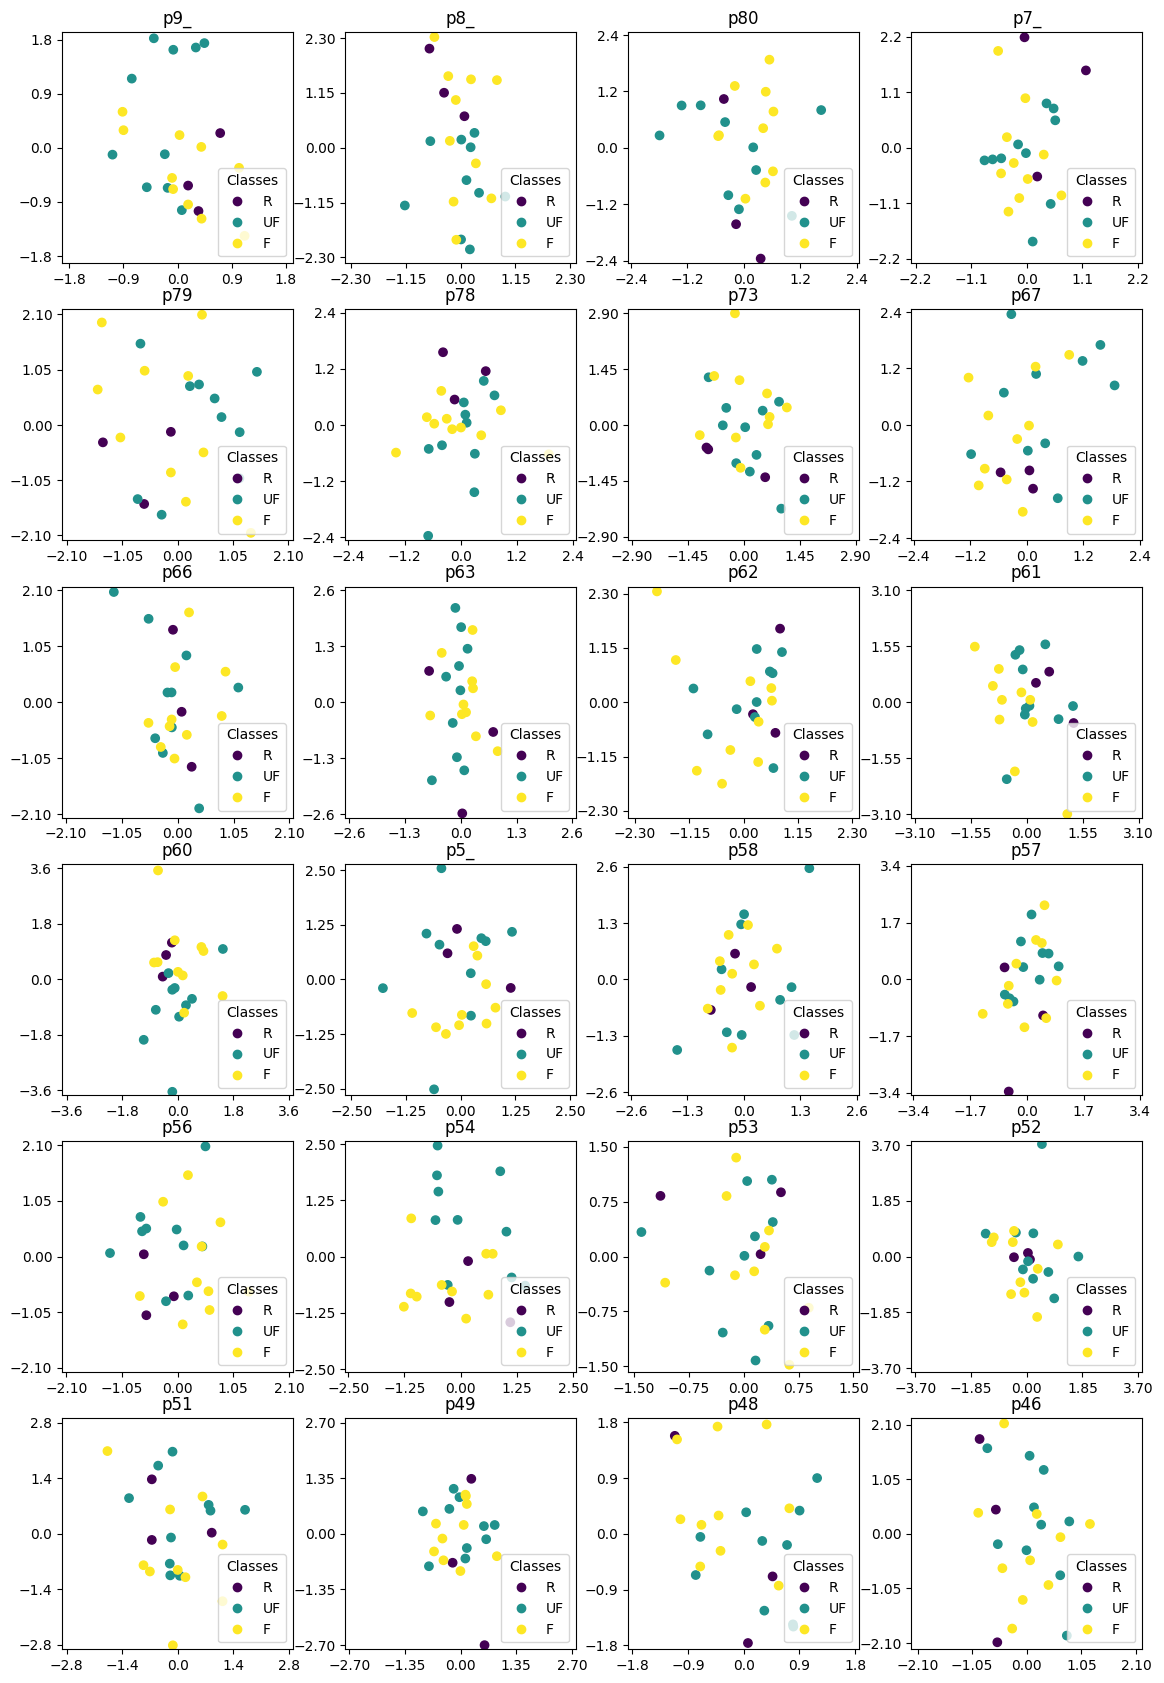

In [93]:
fig, axes = plt.subplots(6,4, figsize=(14,21))
for i,ax in zip(range(len(patients_in_group)),axes.ravel()):
    y1 = np.array(pd.Series(all_data[i]['Event'],dtype=t).cat.codes)

    scatter = ax.scatter(patient_data_pca[i][first_feature], patient_data_pca[i][second_feature], c=y1)
    max_val = np.max(np.append(abs(patient_data_pca[i][first_feature]),abs(patient_data_pca[i][second_feature]))) 
    ax.set_ylim(-max_val-0.1,max_val+0.1)
    ax.set_xlim(-max_val-0.1,max_val+0.1)
    ax.set_xticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])
    ax.set_yticks([-round(max_val,1), -round(max_val,1)/2,0,round(max_val,1)/2, round(max_val,1)])

    ax.set_aspect('equal', adjustable=None, anchor=None, share=False)
    ax.legend(
        scatter.legend_elements()[0],
        ['R', 'UF', 'F'],
        title="Classes",
        loc = 'lower right'
    )
    ax.set_title(patients_in_group[i])

